# poisson equation in 2d


- Poisson Problem also describes the stationary heat equation.

**Poisson equation** <br />
Find  $u \in C^2(\Omega)\cap C(\overline{\Omega})$ with
$$\left \{ \begin{array}{rcll}- \triangle u  & = & f & \mbox{in } \Omega\\
u & = & 0 & \mbox{auf } \partial \Omega\\ \end{array} \right.$$
for $\Omega=(0,1)^2$ and $f \in C(\Omega)$.

With $f = 0$ the equation is known as *laplace equation*

**Laplacian** <br />
$\triangle u := \sum_{i=1}^d \frac{\partial ^2 u}{\partial x_i^2}$

- equidistant gridsize: $h= \frac 1 N$,
$N \in \mathbb{N}$
- set of all gridpoints
$$Z_h := \left\{ (x,y) \in \overline{\Omega} \ \mid \ x=z_1h, \ y=z_2h \text{ mit } z_1,z_2 \in \mathbb{Z} \right\}.$$
- inner gridpoints: $\omega_h := Z_h \cap \Omega$

- approximation of $\frac{\partial ^2 u}{\partial x^2} (x,y)$
$$\frac{u(x -h,y) - 2 u(x,y) + u(x+h,y)}{h^2} = \frac{\partial ^2 u}{\partial
  x^2} (x,y) + \mathcal{O}(h^2)$$
- approximation of $\frac{\partial ^2 u}{\partial y^2} (x,y)$
$$\frac{u(x ,y-h) - 2 u(x,y) + u(x,y+h)}{h^2} = \frac{\partial ^2 u}{\partial
  y^2} (x,y) + \mathcal{O}(h^2)$$
- the sum gives the approximation for $\triangle u(x,y)$:
$$\frac{1}{h^2} \left( u(x,y-h) + u(x-h,y) - 4 u(x,y) + u(x,y+h) +
 u(x+h,y)  \right)$$ 

- definition $u_{i,j}:=u(ih,jh)$ ergibt an Gitterpunkten $(ih,jh)$
$$-u_{i,j-1} - u_{i-1,j} + 4 u_{i,j} - u_{i+1,j} - u_{i,j+1} = h^2 f_{ij}$$
with $i,j \in \{ 1, \dots , N-1 \}$ and $f_{ij}:=f(ih,jh)$. 
- boundary conditions
$u_{0,i}=u_{N,i}=u_{i,0}=u_{i,N}=0$, $i=0, \dots ,N$.

- save 2D-values of $u$ in a vector: shape the inner variables
$$\begin{array}{cccc}
u(h,(N-1)h) & u(2h,(N-1)h) & \ldots & u((N-1)h,(N-1)h)\\
\vdots & \vdots & \vdots & \vdots \\
u(h,2h) & u(2h,2h) & \ldots & u((N-1)h,2h)\\
u(h,h), & u(2h,h) & \ldots & u((N-1)h,h)\\
\end{array}$$

this gives the vector $U_{i+(N-1)(j-1)}=u_{i,j}$.


Linear system for $U=(U_i)_{i=1}^{(N-1)^2}$
$$A U = F$$
with 

- $F:=(f_i)_{i=1}^{(N-1)^2}$ mit $f_{i+(N-1)(j-1)}=f(ih,jh)$, $i,j \in \{1,
\dots ,N-1 \}$,
- $$A  :=  \frac{1}{h^2} tridiag(-I_{N-1}, T, -I_{N-1}) \in \mathbb{R}^{(N-1)^2
 \times (N-1)^2},$$
$$T := tridiag(-1,4,-1) \in \mathbb{R}^{(N-1)\times (N-1)}.$$

In [1]:
{-# LANGUAGE NoMonomorphismRestriction #-}
import Numeric.Container
import Numeric.LinearAlgebra.Algorithms
import Numeric.LinearAlgebra.Util

import Control.DeepSeq (force)

idx2grid :: Int -> Int -> (Int, Int)
idx2grid n i = (i `mod` n, i `div` n)

idxf :: Int -> (Int, Int) -> Double
idxf n (i, j)
    | i == j                        = 4
    | xi == xj && abs(yi - yj) == 1 = -1
    | yi == yj && abs(xi - xj) == 1 = -1
    | otherwise                     = 0
    where (xi, yi) = idx2grid n i
          (xj, yj) = idx2grid n j

poisson :: ([(Double, Double)], Matrix Double, Vector Double)
poisson = (mesh, reshape (n-1) $ head . toColumns $ loes, f) 
      where
          n = 50
          -- coordinates
          x = linspace (n+1) (0,1::Double)
          h = x @> 1
          -- inner points
          xInner = subVector 1 (n-1) x
          mesh = [ (xj, yj) | xj <- toList xInner , yj <- toList xInner ]
          -- laplace matrix
          a = buildMatrix ((n-1)^2) ((n-1)^2) (idxf (n-1)) :: Matrix Double
          -- right hand side
          f = fromList $ map (\(x, y) -> (h^2)*x*(y^4)) mesh
          -- solve linear system
          loes = linearSolve a (asColumn f)

(me, loes, f) = poisson



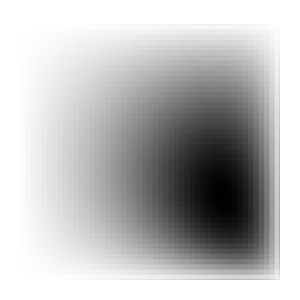

In [2]:
import Graphics.Rendering.Plot

setPlots 1 1 >> withPlot (1, 1) (setDataset loes)

In [4]:
-- write out matrices to visualize with python
(xl,yl) = unzip me
xmat = reshape 49 (fromList xl)
ymat = reshape 49 (fromList yl)
-- create x and y matrix
saveMatrix "xmat.txt" "%f" xmat
saveMatrix "ymat.txt" "%f" ymat
saveMatrix "zmat.txt" "%f" loes 
-- ../vis.py -x xmat.txt -y ymat.txt -z zmat.txt -t image


<img src="../images/poisson.png"></img>

## parallization

lets do the same in parallel using repa.

In [3]:
import Data.Array.Repa as R hiding ((++))

poissonOperator :: Int -> Array U DIM2 Double -> Array D DIM2 Double
poissonOperator n arr = fromFunction ext getElem
    where ext = extent arr
          get idx = if inShape ext idx then index arr idx else 0
          getElem (Z:.i:.j) = ( - get (Z:.(i-1):.j) - get (Z:.(i+1):.j)
                                - get (Z:.i:.(j-1)) - get (Z:.i:.(j+1))
                                + 4*get (Z:.i:.j)) 
                              * fromIntegral (n^2)

rhs :: Int -> Array U DIM2 Double
rhs n = computeS $ fromFunction (Z:.n:.n) $ \(Z:.i:.j) -> f (toCoord i) (toCoord j)
    where h = 1 / fromIntegral n
          toCoord k = h*fromIntegral k + 0.5
          f x y = x*(y^4)

instead of HMatrix's `linearSolve`, we need a solver that works with Repa arrays.

## conjugate gradient solver

CG is a simple, efficient iterative solver for linear systems $A x = y$ with positive definite matrix A (i.e. $x^T A x \geq 0$ for all $x$).

In [4]:
{-# LANGUAGE BangPatterns #-}
{-# LANGUAGE ScopedTypeVariables #-}

import Control.Monad.Identity
import Data.Array.Repa as R hiding ((++))

data CGState sh = CGState { cgx :: Array U sh Double
                          , cgp :: Array U sh Double
                          , cgr :: Array U sh Double
                          , cgr2 :: Double
                          }

`CGState` is the state of a CG iteration.

CG takes a function implementing a linear operator (type `Array U sh -> Array D sh `), a right hand side and an initial guess and returns the (lazy, infinte) list of the `CGState`s of all iterations.

Computations use Repa's parallel computation in a straight-forward way and needs to be performed in a monad. We use the `Identity` monad which does essentially nothing except for providing the sequencing. All operations are performed strictly using `BangPatterns`.

In [5]:
cg :: Shape sh => (Array U sh Double -> Array D sh Double) -> Array U sh Double -> Array U sh Double-> [CGState sh]
cg op rhs initial =
    runIdentity $ do
      !rInit <- computeP $ rhs -^ op initial
      !r2Init <- normSquaredP rInit
      return $ iterate cgStep (CGState initial rInit rInit r2Init)
        where normSquaredP = sumAllP . R.map (^(2::Int))
              scale a = R.map (* a)
              -- the main iteration; maps a CGState to another CGState
              cgStep (CGState x p r r2) =
                  runIdentity $ do
                    -- need inline type annotation here because computeP is polymorphic in its
                    -- output type (syntax like this requires ScopedTypeVariables)
                    !(q :: Array U sh Double) <- computeP $ op p
                    !qp <- sumAllP $ q *^ p
                    let alpha = r2 / qp
                    !x' <- computeP $ x +^ scale alpha p
                    !r' <- computeP $ r -^ scale alpha q
                    !r2' <- normSquaredP r'
                    let beta = r2' / r2
                    !p' <- computeP $ r' +^ scale beta p
                    return $ CGState x' p' r' r2'

Using lazyness, the iterations can be decoupled from stopping rule and output of information.

In [6]:
takeUntil :: (a -> Bool) -> [a] -> [a]
takeUntil _ [] = []
takeUntil predicate (x:xs)
    | predicate x = [x]
    | otherwise   = x : takeUntil predicate xs

process :: Monad m => [a] -> (a -> m ()) -> m a
process xs f = foldM (\_ x -> f x >> return x) undefined xs

runCG :: Shape sh => Double -> (Array U sh Double -> Array D sh Double) -> Array U sh Double -> IO (Array U sh Double)
runCG tol op rhs = do
    let initial = computeS $ fromFunction (extent rhs) (const 0)
    let steps' = cg op rhs initial
    let r20 = cgr2 $ head steps'
    let steps = takeUntil (\x -> sqrt (cgr2 x / r20) < tol) steps'
    result <- process (zip [(1::Int)..] steps) $ \(n, cgs) ->
        putStrLn $ show n ++ "  " ++ show (sqrt $ cgr2 cgs / r20)
    return $ cgx . snd $ result

- `takeUntil` is like `takeWhile`, but also returns the final iterate (why waste it?).

- `process` runs over a list, performs a monadic action on each element and returns the last element. It does not retain the start of the list while iterating, so it gets garbage collected properly.

- `runCG` executes `cg` with initial guess 0, a stopping rule based on residuals relative to the first initial guess, and outputs the residual while iterating.

### Example

In [7]:
solution <- let n = 50 in runCG 1e-3 (poissonOperator n) (rhs n)

1  1.0
2  2.4152126660166626
3  2.314299876237571
4  2.429156173499013
5  2.4272864557075406
6  2.2400987961510577
7  2.2347846402460947
8  2.065436289032053
9  2.042287105267274
10  1.9008950949164025
11  1.8664952270627286
12  1.7473562298623355
13  1.7069409539437987
14  1.6047256220742743
15  1.5614827935179003
16  1.4722851132007329
17  1.428057318196246
18  1.3490580859012
19  1.304875763106223
20  1.2339945797426473
21  1.1904010907971159
22  1.1260581818556328
23  1.0833031723938824
24  1.0242663012580444
25  0.9824224816504297
26  0.9277088293713385
27  0.886744444923978
28  0.8355569702854143
29  0.7953822099201495
30  0.7470678681498778
31  0.7075679720916241
32  0.6616228495005798
33  0.6229685318658391
34  0.5806232389502212
35  0.5489675143953446
36  0.5241048366601045
37  0.5151287430150817
38  0.4977583947010726
39  0.4623081746563679
40  0.41992828885580524
41  0.3997935198674482
42  0.3783985603532077
43  0.34695724713488124
44  0.32324751949022895
45  0.3047672683863

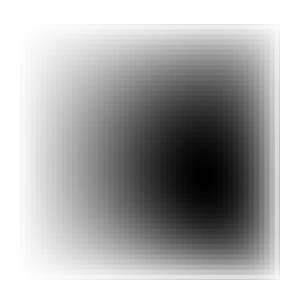

In [9]:
import Data.Packed.Repa

setPlots 1 1 >> withPlot (1, 1) (setDataset $ repaToMatrix $ copyS solution)

## Stencils

Operators like `poissonOperator` are a frequent pattern: each element of the resulting array is a linear combination of the surrounding elements of the input array.

Repa has special means for constructing such operations in 2-d: Stencils.

```haskell
makeStencil2 :: Num a => Int -> Int -> (DIM2 -> Maybe a) -> Stencil DIM2 a
```

In [11]:
import Data.Array.Repa.Stencil.Dim2
import Data.Array.Repa.Stencil

poissonStencil :: Integer -> Stencil DIM2 Double
poissonStencil n = makeStencil2 3 3 getElem
    where val = fromIntegral n^2
          getElem (Z:. -1 :.  0) = Just $ -val
          getElem (Z:.  1 :.  0) = Just $ -val
          getElem (Z:.  0 :. -1) = Just $ -val
          getElem (Z:.  0 :.  1) = Just $ -val
          getElem (Z:.  0 :.  0) = Just $ 4*val
          getElem _              = Nothing

Stencils are applied to 2-d arrays using

```haskell
mapStencil2 :: Source r a => Boundary a -> Stencil DIM2 a -> Array r DIM2 a -> Array PC5 DIM2 a
```

- `Boundary a` is a type that handles the boundary conditions. It can be
    - `BoundFixed x` returns a fixed value `x` at the boundary,
    - `BoundConst x` assumes pixels outside the array have the value `x`,
    - `BoundClamp` extends the boundary values to outside the boundary,
    where `x :: a`
- `PC5` is a special representation for stencil results; it is defined as
    ```haskell
    type PC5 = P C (P (S D) (P (S D) (P (S D) (P (S D) X))))
    ```
    (No need to understand this.)
- `PC5` arrays can be converted to `D` arrays using the polymorphic function
    ```haskell
    delay :: (Shape sh, Source r e) => Array r sh e -> Array D sh e
    ```

An alternative way to solve the Poisson problem with Repa is then

In [12]:
poissonOperator :: Integer -> Array U DIM2 Double -> Array D DIM2 Double
poissonOperator n = delay . mapStencil2 (BoundConst 0) (poissonStencil n)

solution <- let n = 50 in runCG 1e-3 (poissonOperator n) (rhs n)

1  1.0
2  2.4152126660166617
3  2.3142998762375697
4  2.4291561734990084
5  2.4272864557075344
6  2.240098796151052
7  2.2347846402460894
8  2.0654362890320472
9  2.042287105267269
10  1.9008950949163999
11  1.866495227062727
12  1.7473562298623346
13  1.706940953943801
14  1.604725622074277
15  1.5614827935179052
16  1.4722851132007357
17  1.42805731819625
18  1.3490580859012025
19  1.304875763106225
20  1.2339945797426493
21  1.1904010907971143
22  1.12605818185563
23  1.0833031723938806
24  1.0242663012580417
25  0.9824224816504274
26  0.927708829371335
27  0.886744444923975
28  0.8355569702854102
29  0.7953822099201452
30  0.7470678681498721
31  0.7075679720916201
32  0.6616228495005767
33  0.6229685318658362
34  0.5806232389502177
35  0.5489675143953409
36  0.5241048366600992
37  0.5151287430150748
38  0.49775839470106564
39  0.4623081746563614
40  0.4199282888557984
41  0.3997935198674416
42  0.3783985603532022
43  0.34695724713487747
44  0.3232475194902257
45  0.3047672683863378

### Stencil syntax

There is special syntax for stencils. The `poissonStencil` above can be produced more easily by

In [42]:
{-# LANGUAGE QuasiQuotes #-}

poissonStencil :: Stencil DIM2 Double
poissonStencil = [stencil2|  0 -1  0
                            -1  4 -1
                             0 -1  0 |]

The syntax is processed at compile time, so scaling is not possible in this version:

In [43]:
{-# LANGUAGE QuasiQuotes #-}

poissonStencil :: Stencil DIM2 Double
poissonStencil n = [stencil2|    0    (-val)    0
                              (-val) (4*val) (-val)
                                 0    (-val)    0   |]
    where val = fromIntegral n^2

Exception when trying to run compile-time code:
  Prelude.read: no parse
Code: Language.Haskell.TH.Quote.quoteExp
        stencil2
        "    0    (-val)    0\n\
        \                              (-val) (4*val) (-val)\n\
        \                                 0    (-val)    0   "